In [1]:
from mpc import *
from IPython.display import display, Markdown, Latex


### Simulation parameters
Defines the total simulation time and sampling time.

In [2]:
# Total simulation time: 24h (1440m)
total_time = 1440

# Sampling time: 1m
t_step = 1

# Number of control step: total_time/t_step = 1440
steps = int(total_time/t_step)

# Get average trajectory every 240 m
avg_period = 240

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


### Control loop
It defines the parameters of the controller, instantiates the object of the model class to be controlled and the object of the controller class and starts the control loop.

In [3]:
setup_mpc = {
    'n_robust': 1,
    'n_horizon': 10,  # Time horizon
    't_step': t_step,
    'store_full_solution': False,
}

toggle = ToggleSwitchModel(True, LacI_ref, TetR_ref, t_step, total_time, avg_period)
mpc_controller = ControllerMPC(toggle, t_step, setup_mpc, True)


In [4]:
%%capture
mpc_controller.control_loop(x_0, steps, 'stochastic', 10)

### Performance metrics and results plot
It calculates ISE and ITAE values and plots closed-loop simulations.

#### Performance metrics


<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | 175.43     |
| ITAE       | 3.03e+05    |


#### Results plot

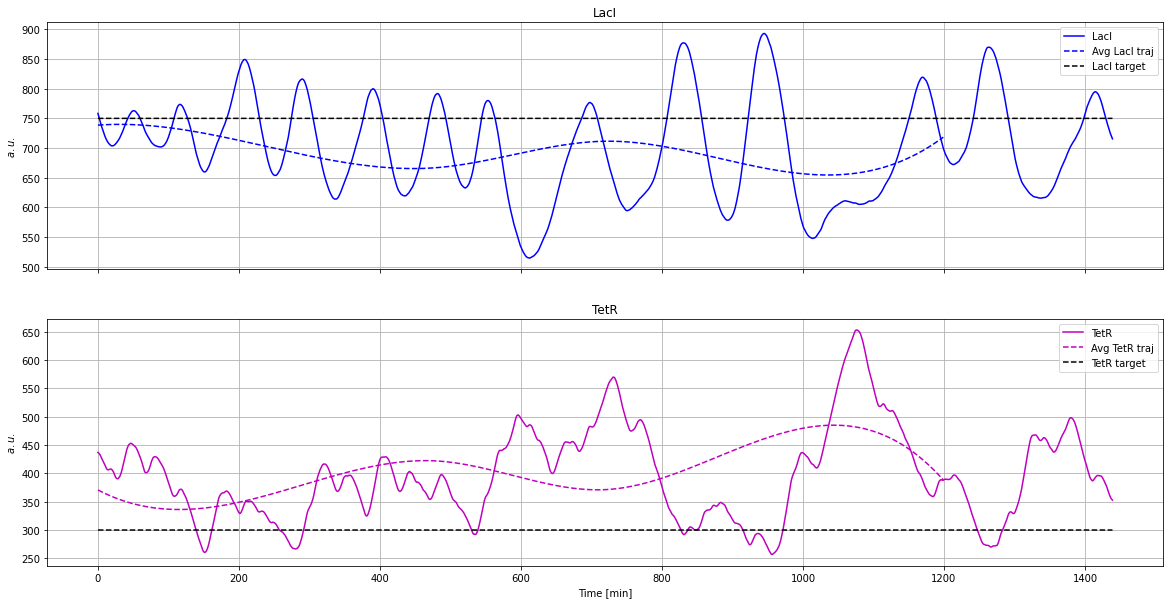

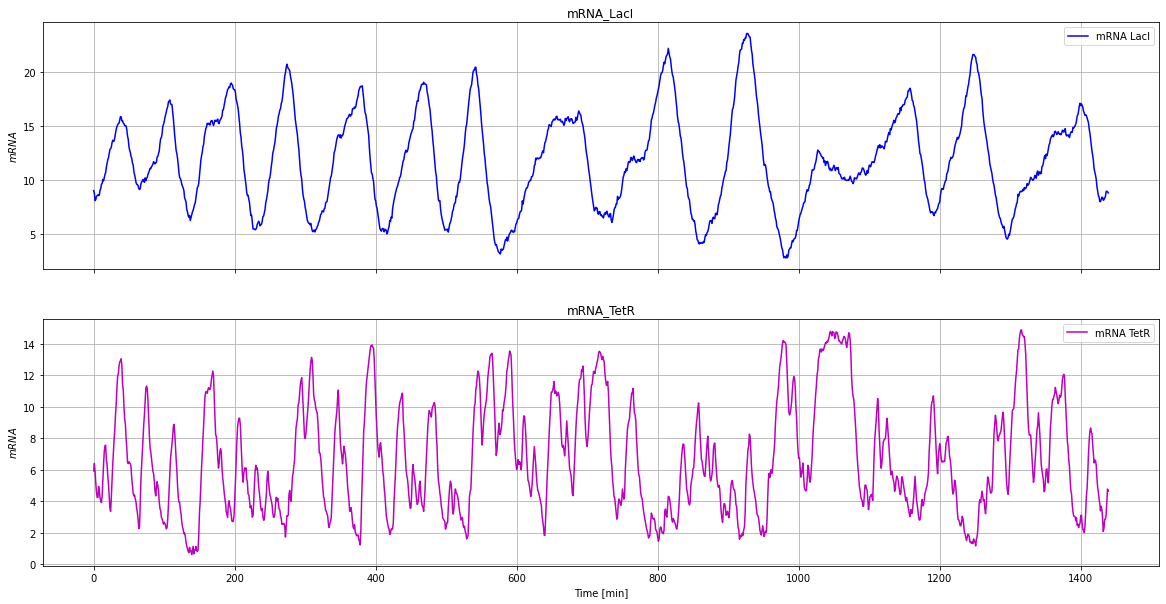

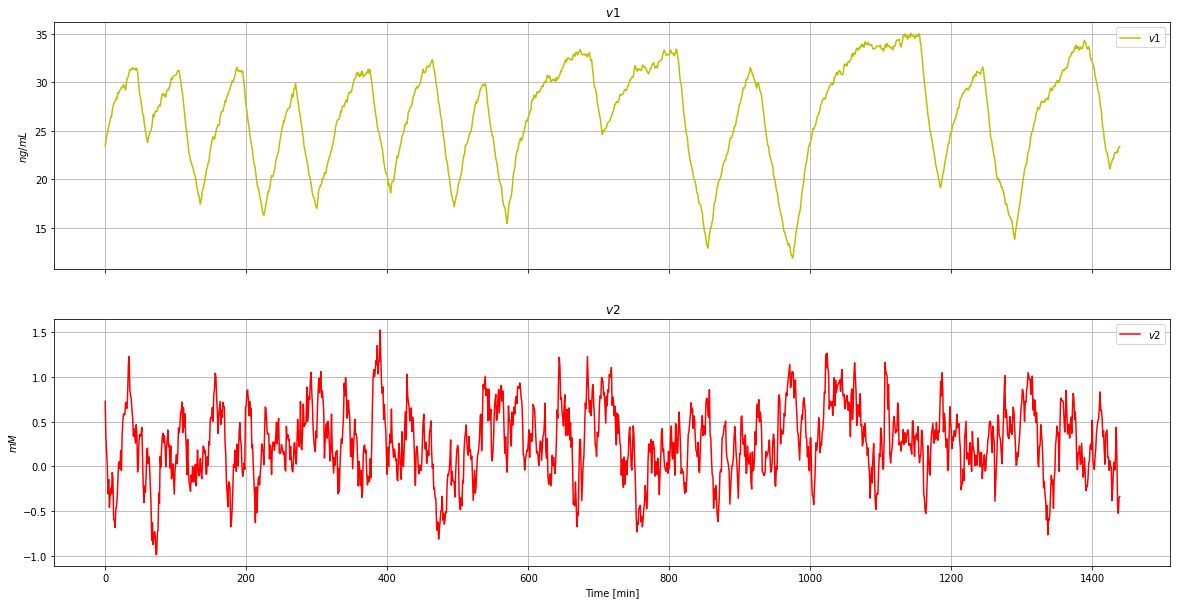

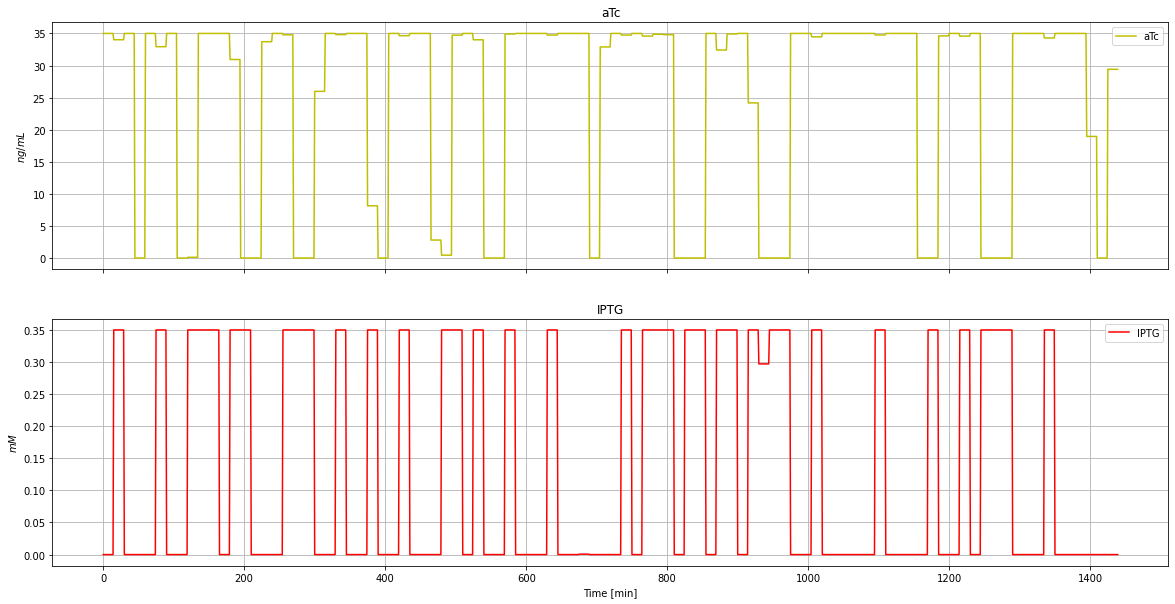

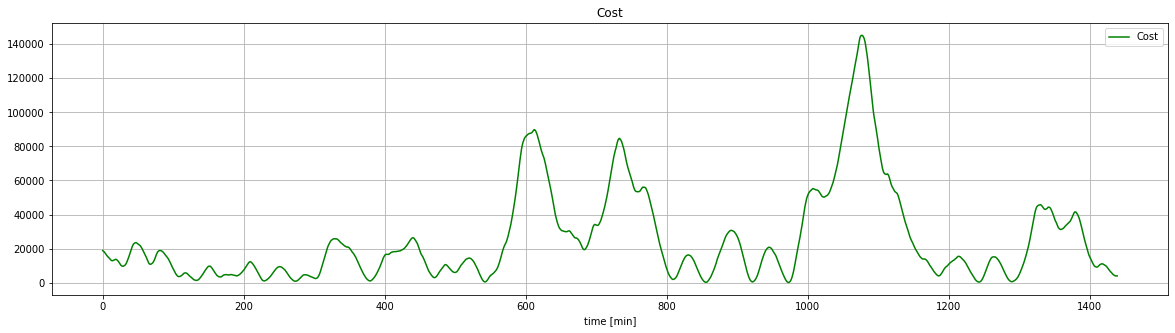

In [5]:
display(Markdown('#### Performance metrics'))
metrics = """
<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | {ISE}     |
| ITAE       | {ITAE}    |
""".format(ISE="{:.2f}".format(toggle.trajectories['ISE']), ITAE=format(toggle.trajectories['ITAE'], '.2e'))

display(Markdown(metrics))

display(Markdown('#### Results plot'))
figures, lines = toggle.plot_results()


### Plots animation
It animates closed-loop simulations and exports them in mp4 format.

In [6]:
toggle.animate_results('stochastic', 'proteins', toggle.update_protein,
                       figures[0], (toggle.trajectories, lines[0:6], np.arange(0, total_time - ((total_time-1) % avg_period) - 1, t_step)), steps)
toggle.animate_results('stochastic', 'mRNAs', toggle.update_mRNA, figures[1], (toggle.trajectories, lines[6:8]), steps)
toggle.animate_results('stochastic', 'internal_inducers', toggle.update_internal_inducers, figures[2], (toggle.trajectories, lines[8:10]), steps)
toggle.animate_results('stochastic', 'external_inducers', toggle.update_external_inducers, figures[3], (toggle.trajectories, lines[10:12]), steps)
toggle.animate_results('stochastic', 'cost', toggle.update_cost, figures[4], (toggle.trajectories, lines[12:13]), steps)


### Mean and standard deviation of state trajectories

In this section the mean and the standard deviation of the state trajectories are computed and plotted, starting from the results of the previous simulations.

In [7]:
episodes = 10

samples = int(total_time/t_step)

states = np.empty((episodes, samples, 6))
inputs = np.empty((episodes, samples, 2))
metrics = np.empty((episodes, 2))

for i in range(episodes):
    with open('./data/stochastic/results' + str(i) + '.json') as f:
        data = json.load(f)
        states[i, :, 0] = data['states']['mRNA_LacI']
        states[i, :, 1] = data['states']['mRNA_TetR']
        states[i, :, 2] = data['states']['LacI']
        states[i, :, 3] = data['states']['TetR']
        states[i, :, 4] = data['states']['v1']
        states[i, :, 5] = data['states']['v2']
        inputs[i, :, 0] = data['inputs']['aTc']
        inputs[i, :, 1] = data['inputs']['IPTG']
        metrics[i, 0] = data['ISE']
        metrics[i, 1] = data['ITAE']

#### Mean and standard deviation between the trajectories obtained in the different episodes

In [8]:
states_mean = np.array([[np.mean(states[:, i, 0]), np.mean(states[:, i, 1]), np.mean(states[:, i, 2]), np.mean(
    states[:, i, 3]), np.mean(states[:, i, 4]), np.mean(states[:, i, 5])] for i in range(steps)])

states_std = np.array([[np.std(states[:, i, 0]), np.std(states[:, i, 1]), np.std(states[:, i, 2]), np.std(
    states[:, i, 3]), np.std(states[:, i, 4]), np.std(states[:, i, 5])] for i in range(steps)])

inputs_mean = np.array([[np.mean(inputs[:, i, 0]), np.mean(inputs[:, i, 1])] for i in range(steps)])

inputs_std = np.array([[np.std(inputs[:, i, 0]), np.std(inputs[:, i, 1])] for i in range(steps)])

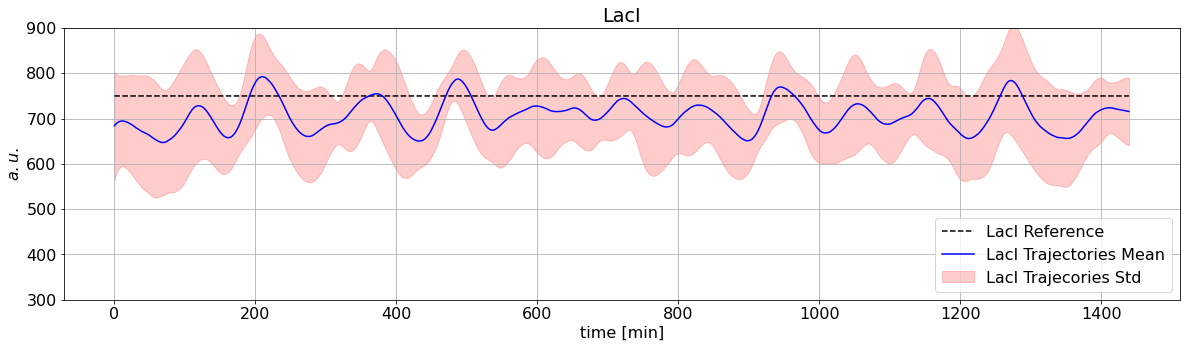

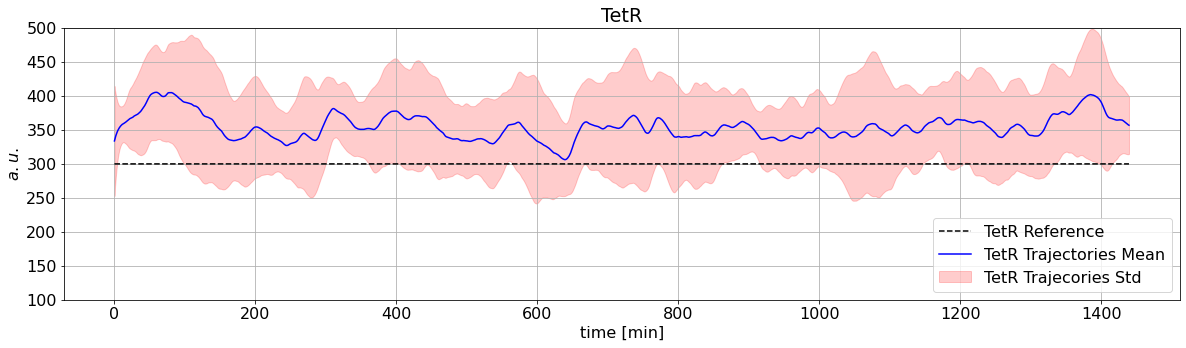

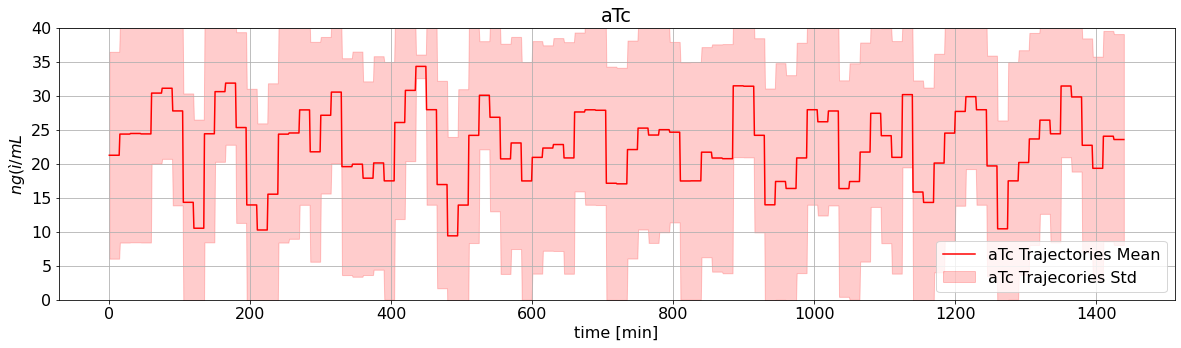

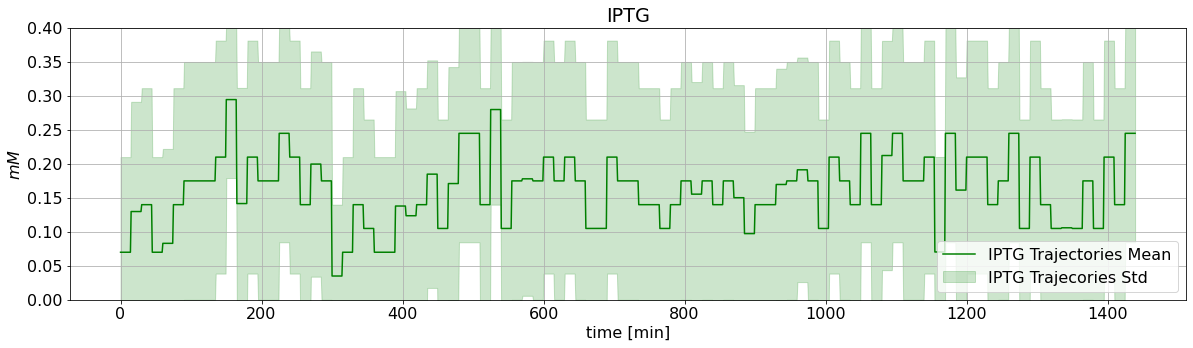

In [9]:
fig_x = 20
fig_y = 5

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 16

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

time = np.arange(0, total_time, t_step)

axes.set_ylabel(r'$a.u.$')
axes.set_title('LacI')
axes.plot(time, LacI_ref*np.ones(len(time)), color='k', linestyle='--')
axes.plot(time, states_mean[:, 2], color='b')
axes.fill_between(time, states_mean[:, 2] - states_std[:, 2], states_mean[:, 2] + states_std[:, 2], color='r', alpha=0.2)
axes.legend(['LacI Reference', 'LacI Trajectories Mean', 'LacI Trajecories Std'], loc='lower right')
axes.set_xlabel('time [min]')
axes.set_ylim(300, 900)


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/average_trajectory/LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$a.u.$')
axes.set_title('TetR')
axes.plot(time, TetR_ref*np.ones(len(time)), color='k', linestyle='--')
axes.plot(time, states_mean[:, 3], color='b')
axes.fill_between(time, states_mean[:, 3] - states_std[:, 3], states_mean[:, 3] + states_std[:, 3], color='r', alpha=0.2)
axes.legend(['TetR Reference', 'TetR Trajectories Mean', 'TetR Trajecories Std'], loc='lower right')
axes.set_xlabel('time [min]')
axes.set_ylim(100, 500)


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/average_trajectory/TetR.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$ng(ì/mL$')
axes.set_title('aTc')
axes.plot(time, inputs_mean[:, 0], color='r')
axes.fill_between(time, inputs_mean[:, 0] - inputs_std[:, 0], inputs_mean[:, 0] + inputs_std[:, 0], color='r', alpha=0.2)
axes.legend(['aTc Trajectories Mean', 'aTc Trajecories Std'], loc='lower right')
axes.set_xlabel('time [min]')
axes.set_ylim(0, 40)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/average_trajectory/aTc.png')


figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$mM$')
axes.set_title('IPTG')
axes.plot(time, inputs_mean[:, 1], color='g')
axes.fill_between(time, inputs_mean[:, 1] - inputs_std[:, 1], inputs_mean[:, 1] + inputs_std[:, 1], color='g', alpha=0.2)
axes.legend(['IPTG Trajectories Mean', 'IPTG Trajecories Std'], loc='lower right')
axes.set_xlabel('time [min]')
axes.set_ylim(0, 0.40)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/average_trajectory/IPTG.png')


In [10]:
display(Markdown('#### Performance metrics'))
metrics = """
<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | {ISE}     |
| ITAE       | {ITAE}    |
""".format(ISE = "{:.2f}".format(np.mean(metrics[:, 0])), ITAE = format(np.mean(metrics[:, 1]), '.2e'))

display(Markdown(metrics))

#### Performance metrics


<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | 67.32     |
| ITAE       | 1.40e+05    |


#### Average trajectory with a moving window of period 240m for each episode

In [11]:
# Average trajectory for each state in each episode
avg_samples_range = int(avg_period/t_step)
avg_x = np.arange(0, total_time, avg_period)
avg_stop_time = total_time - ((total_time-1) % avg_period) - 1
avg_time = np.arange(0, avg_stop_time, t_step)

states_average = np.zeros((episodes, avg_stop_time, 6))

for i in range(episodes):

    for j in range(6):

        x_avg = [np.mean(states[i, x:x + avg_samples_range, j]) for x in range(0, steps, avg_samples_range)]
        fx_avg = CubicSpline(avg_x, x_avg)
        states_average[i, :, j] = fx_avg(avg_time)


#### Mean and standard deviation between the average trajectories

In [12]:
mean = np.zeros((avg_stop_time, 6))
std = np.zeros((avg_stop_time, 6))

for i in range(avg_stop_time):
    for j in range(6):
        mean[i, j] = np.mean(states_average[:, i, j])
        std[i, j] = np.std(states_average[:, i, j])


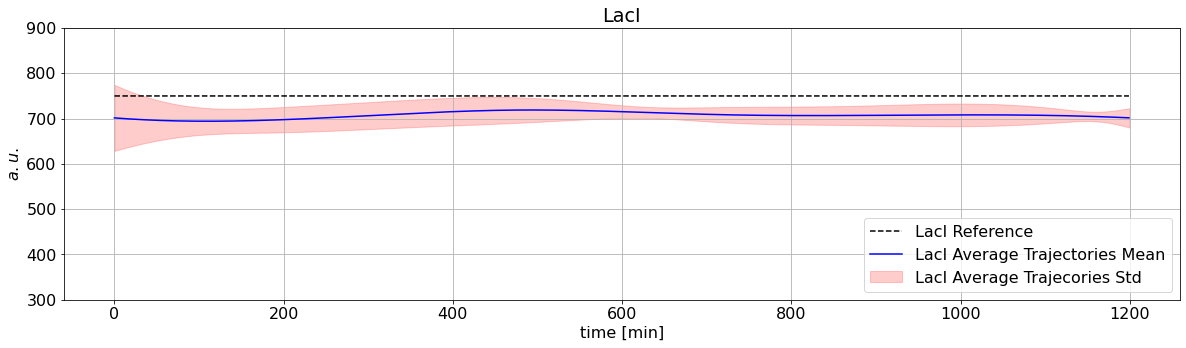

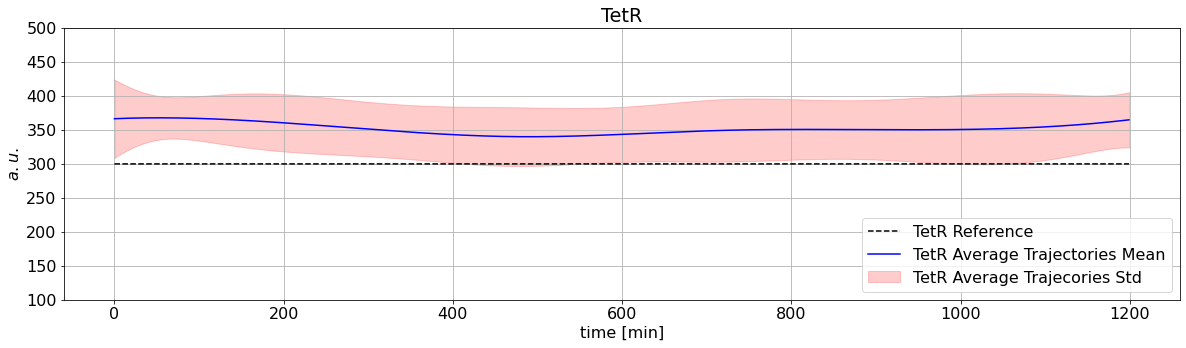

In [13]:
fig_x = 20
fig_y = 5

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 16

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$a.u.$')
axes.set_title('LacI')
axes.plot(avg_time, LacI_ref*np.ones(len(avg_time)), color='k', linestyle='--')
axes.plot(avg_time, mean[:, 2], color='b')
axes.fill_between(avg_time, mean[:, 2] - std[:, 2], mean[:, 2] + std[:, 2], color='r', alpha=0.2)
axes.legend(['LacI Reference', 'LacI Average Trajectories Mean', 'LacI Average Trajecories Std'], loc='lower right')
axes.set_xlabel('time [min]')
axes.set_ylim(300, 900)


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel(r'$a.u.$')
axes.set_title('TetR')
axes.plot(avg_time, TetR_ref*np.ones(len(avg_time)), color='k', linestyle='--')
axes.plot(avg_time, mean[:, 3], color='b')
axes.fill_between(avg_time, mean[:, 3] - std[:, 3], mean[:, 3] + std[:, 3], color='r', alpha=0.2)
axes.legend(['TetR Reference', 'TetR Average Trajectories Mean', 'TetR Average Trajecories Std'], loc='lower right')
axes.set_xlabel('time [min]')
axes.set_ylim(100, 500)


figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/TetR.png')
